In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flpoAgent
import importlib
import random
from scipy.spatial.distance import cdist
import createEnv
from scipy.optimize import Bounds, LinearConstraint, minimize
import supporting_functions
from matplotlib.cm import get_cmap

n_waypoints: 3 
n_agents: 2 
CAT:
[4. 4. 4.]
---------
wp_locations:
[[-6.91674315e+00  4.80099393e+00]
 [ 9.95266300e+02  6.74787868e-01]
 [-9.70850075e+00  1.00837494e+03]] 
mask:
[[0 1 1]
 [1 0 0]
 [1 0 0]] 
dist_mat:
[[1.00000000e+08 1.00219154e+03 1.00357783e+03]
 [1.00219154e+03 1.00000000e+08 1.00000000e+08]
 [1.00357783e+03 1.00000000e+08 1.00000000e+08]] 
wp_weights:
[0.33333333 0.33333333 0.33333333]
---------
agent_weights:
[1. 1.] 
sd_mat:
[[2 1]
 [1 2]] 
eta_arr: 
processing_time:
[[4.70547108 0.         4.04245205]
 [4.10407527 3.97075483 0.        ]] 
speed_lim_mat:
[[5.38401999e-01 7.37812051e+01]
 [2.44292129e-02 7.35107228e+01]] 
sched_mat:
[[ 3.34214276 95.69493363  0.        ]
 [28.3828353   0.         94.42251361]]
reach_mat
filter_wp:
[[1. 1. 1.]
 [1. 1. 1.]]
transport_cost:
[-1.95096080e+08 -1.95097344e+08]
conflict_cost:
[0.09057216 0.09057216 0.09057216]


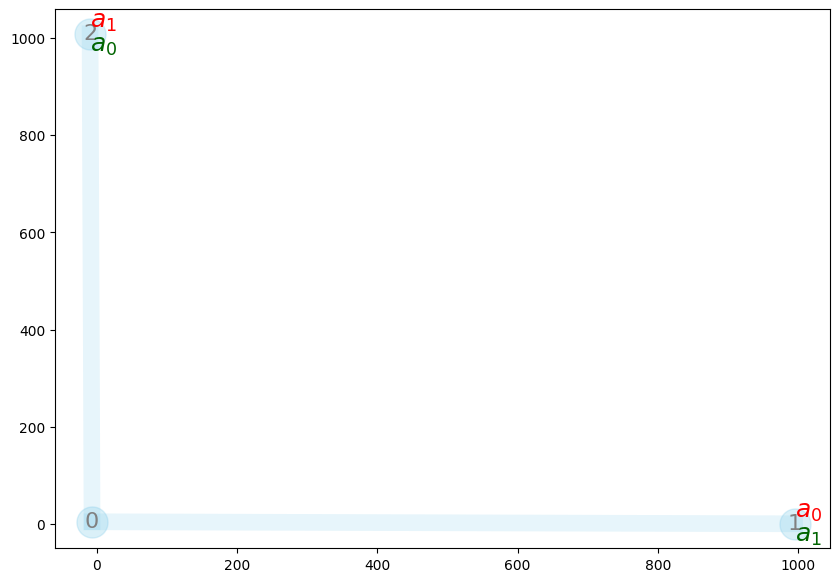

In [14]:
importlib.reload(flpoAgent)
importlib.reload(createEnv)
importlib.reload(supporting_functions)

# generate waypoints and the adjacency matrix
n_waypoints = 3
n_agents = 2
tolArray = np.random.uniform(4.0, 4.0, n_waypoints)

# Grid network parameters
grid_params = {
    'type':'grid',
    'n_points':n_waypoints,
    'grid_size':1000,
    'noise_factor':10
}

# Ring network parameters
ring_params = {
    'type':'ring',
    'num_rings':3,
    'points_per_ring':int(n_waypoints/3),
    'center_distance':200,
    'deformation_level':50.0,
    'extra_connections':0.00,
    'missing_connections':0.05
}

# create a mars environment
mars = createEnv.MARS(
    n_waypoints, 
    n_agents, 
    tolArray, 
    grid_params, 
    seed=12, 
    printFlag=True)

# compute conflict cost
beta0=1e-8
gamma_t = 5
gamma_c = 7.5
coeff_t = 50
coeff_c = 5.0
# calculate conflict cost
# print(f'mars_schedule:\n{np.round(mars.sched_mat,2)}')
# Xi = mars.agents[1].returnStageWiseCost(mars.sched_mat[1,:], mars.dist_mat, gamma_t, coeff_t)
# Pb = mars.agents[1].getPathAssociations(mars.sched_mat[1,:], mars.dist_mat, beta0, gamma_t, coeff_t)
# print(f'agent start:{mars.agents[1].s}\nprobability:\n{Pb[1]}\nstageWiseCost:{Xi[1]}')

reach_mat = mars.calc_agent_reach_mat(
        mars.sched_mat, 
        beta=beta0, gamma=gamma_t, coeff=coeff_t)
filter_wp = np.ones(shape=reach_mat.shape)
filter_wp[reach_mat <= 1.0e-10] = 0.0 
print(f'reach_mat')
print(f'filter_wp:\n{filter_wp}')
mars.transportCost(mars.sched_mat, beta=beta0, gamma=gamma_t, coeff=coeff_t)
print(f'transport_cost:\n{mars.C_agents}')
mars.conflictCost(mars.sched_mat, gamma=gamma_c, coeff=coeff_c, filter_wp=filter_wp)
print(f'conflict_cost:\n{mars.C_wp_conflict}')

# mars visualization
# agent_routes, agent_schedules, agent_colors = createEnv.calc_agent_routes_and_schedules(mars, Pb_a=[], printRoutes=False)
cmap = get_cmap('tab20')
agent_colors = {a: cmap(i / mars.n_agents) for i, a in enumerate(range(mars.n_agents))}
createEnv.plotNetwork(mars=mars, figuresize=(10,7), routes=[], agent_colors=agent_colors, showEdgeLength=False, plotPaths=False)

# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True)



### Write a code to flatten the scheduling matrix row-wise ($y$) and column-wise ($z$) and construct a linear transformation between them $A$.

In [15]:
def compute_transformation_matrix(rows, cols):
    # Total number of elements
    n = rows * cols

    # Create a basis for all standard basis vectors in column-wise (z) order
    A = np.zeros((n, n))

    for i in range(n):
        # Create one-hot vector in column-wise order
        z = np.zeros((rows, cols))
        # Get the (row, col) index for column-wise flattening
        row = i % rows
        col = i // rows
        z[row, col] = 1

        # Flatten row-wise to get the i-th column of A
        y = z.flatten(order='C')  # 'C' means row-major
        A[:, i] = y

    return A

# compute transformation
Azy = compute_transformation_matrix(mars.n_agents, mars.n_waypoints)
# verify
Tmat = mars.sched_mat
y = Tmat.flatten()
z = (Tmat.T).flatten()
err1 = y - Azy @ z
err2 = Azy.T @ y - z
err3 = np.max(np.abs(Azy.T @ Azy - np.eye(mars.n_agents * mars.n_waypoints)))

# print("Transformation matrix A:z-->y\n", Azy)
# print(f'norms:\tres1 {np.linalg.norm(err1)}\tres2 {np.linalg.norm(err2)}\tres3 {np.linalg.norm(err3)}')


### Formulate and solve the ADMM optimization problem

In [16]:
def lagrangian_y(y, mars, zk, lk, Azy, beta, gamma, coeff, rho=0.1):
    Tmat = y.reshape(-1, mars.n_waypoints)
    # mars.transportCost(Tmat, beta, gamma, coeff) # function y
    mars.transportCost_v1(Tmat, beta) # function y
    phi1_y = np.sum(mars.C_agents)
    linear_term = lk @ y
    quadratic_term = rho/2 * np.linalg.norm(y - Azy @ zk)**2
    cost = phi1_y + linear_term + quadratic_term
    return cost

def lagrangian_z(z, mars, yk1, lk, Azy, gamma, coeff, rho=0.1):
    Tmat = z.reshape(-1, mars.n_agents).T
    mars.conflictCost1(Tmat, gamma, coeff)
    phi2_z = np.sum(mars.C_wp_conflict)
    linear_term = -lk @ (Azy @ z)
    quadratic_term = rho/2 * np.linalg.norm(yk1 - Azy @ z)**2
    cost = phi2_z + linear_term + quadratic_term
    return cost

def update_dual(lk, yk1, zk1, Azy, rho=0.1):
    lk1 = lk + rho * (yk1 - Azy @ zk1)
    return lk1

def admm_iters_at_beta(
    mars, 
    y0, 
    z0, 
    l0, 
    bounds, 
    Azy, 
    beta, 
    n_iters_admm=50, 
    gamma_t=7,
    coeff_t=1,
    gamma_c=7,
    coeff_c=1,
    rho=0.1,
    allowPrint=False):

    # initialization
    yk, zk, lk = y0, z0, l0
    norm_yz_arr, norm_dphi1_yl_arr, norm_dphi2_zl_arr = [], [], []
    
    for i in range(n_iters_admm):

        # update yk given (yk, zk, lk)
        res_y = minimize(
            lagrangian_y,
            yk,
            args = (mars, zk, lk, Azy, beta, gamma_t, coeff_t, rho),
            method='slsqp',
            bounds = bounds,
            options={'disp':0}
        )
        yk1 = res_y.x

        # update zk given (yk1, zk, lk)
        res_z = minimize(
            lagrangian_z,
            zk,
            args = (mars, yk1, lk, Azy, gamma_c, coeff_c, rho),
            method='slsqp',
            bounds = bounds,
            options={'disp':0}
        )
        zk1 = res_z.x

        # update l given (yk1, zk1, lk)
        lk1 = update_dual(lk, yk1, zk1, Azy, rho)

        # jacobians
        jac_y, jac_z = res_y.jac, res_z.jac

        # convergence criteria
        norm_yz = np.max(np.abs(yk1 - Azy @ zk1))
        dphi1_yl = np.max(np.abs(jac_y + lk1))
        dphi2_zl = np.max(np.abs(jac_z - Azy.T @ lk1))

        norm_yz_arr.append(norm_yz)
        norm_dphi1_yl_arr.append(dphi1_yl)
        norm_dphi2_zl_arr.append(dphi2_zl)

        # display results
        if allowPrint:
            print(f'i:{i}\tnorm_yz: {norm_yz:.4f}\tdphi1_yl: {dphi1_yl:.4f}\tdphi2_zl: {dphi2_zl:.4f}')

        # update current variables
        yk = yk1
        zk = zk1
        lk = lk1

    convergence_data = np.zeros(shape=(3, len(norm_yz_arr)))
    convergence_data[0,:] = np.array(norm_yz_arr)
    convergence_data[1,:] = np.array(norm_dphi1_yl_arr)
    convergence_data[2,:] = np.array(norm_dphi2_zl_arr)

    return yk, zk, lk, convergence_data



### Code to perform the ADMM iterations in loop

In [17]:
# lb0 = np.zeros(mars.n_agents * mars.n_waypoints)
# ub0 = 100 * np.ones(mars.n_agents * mars.n_waypoints)
# bounds = Bounds(lb0, ub0)

# y0 = Tmat.flatten()
# z0 = (Tmat.T).flatten() + np.random.multivariate_normal(np.zeros(y.shape), 2e-2 * np.eye(y.shape[0]))
# l0 = np.random.uniform(0.0, 10.0, (y.shape))
# beta = 1e2
# gamma_t = 5
# gamma_c = 7.5
# coeff_t = 50
# coeff_c = 5.0
# rho = 0.01
# norm_yz_arr = []
# primal_dual_res = []

# n_iters_admm = 300

# y1, z1, l1, convergence_data = admm_iters_at_beta(mars, y0, z0, l0, bounds, Azy, beta, n_iters_admm, gamma_t, coeff_t, gamma_c, coeff_c, rho, allowPrint=True)

In [18]:
# norm_yz_arr = convergence_data[0,:]
# norm_dphi1_yl_arr = convergence_data[1,:]
# norm_dphi2_yz_arr = convergence_data[2,:]

# plt.figure(figsize=(14,6))

# plt.subplot(3,1,1)
# plt.plot(norm_yz_arr, marker='x')
# # plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\hat y_k - A \hat z_k|_\infty$')
# plt.grid()

# plt.subplot(3,1,2)
# plt.plot(norm_dphi1_yl_arr, marker='.')
# # plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\nabla \Phi_1(y_{{k}}) + \lambda_k|_\infty$')
# plt.grid()

# plt.subplot(3,1,3)
# plt.plot(norm_dphi2_yz_arr, marker='.')
# plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\nabla \Phi_2(z_{{k}}) - A^T\lambda_k|_\infty$')
# plt.grid()

# plt.show()

### Code to perform Annealing with ADMM iterations

In [19]:
beta_min = 1e-6
beta_max = 1e1
beta_grow = 1.5
beta_arr = []
beta = beta_min
while beta < beta_max:
    beta = beta * beta_grow
    beta_arr.append(beta)
print(f'n_betas: {len(beta_arr)}')

lb0 = np.zeros(mars.n_agents * mars.n_waypoints)
ub0 = 100 * np.ones(mars.n_agents * mars.n_waypoints)
bounds = Bounds(lb0, ub0)

yb = Tmat.flatten()
zb = (Tmat.T).flatten() + np.random.multivariate_normal(np.zeros(y.shape), 1e-3 * np.eye(y.shape[0]))
lib = np.random.uniform(0.0, 10.0, (y.shape))

# gamma_t = 5
# gamma_c = 7.5
# coeff_t = 50
# coeff_c = 5.0
# gamma_t = 7
gamma_c = 7
# coeff_t = 5
coeff_c = 5
rho = 0.01
n_iters_admm = 100

for i, beta in enumerate(beta_arr):
    
    yb1, zb1, lib1, convergence_data_beta = admm_iters_at_beta(
        mars, yb, zb, lib, bounds, Azy, beta, n_iters_admm, 
        gamma_t, coeff_t, gamma_c, coeff_c, rho, 
        allowPrint=False)
    
    norm_yz = convergence_data_beta[0,-1]
    norm_dphi1_yl = convergence_data_beta[1,-1]
    norm_dphi2_yz = convergence_data_beta[2,-1]
    print(f'beta: {beta:.3e}\tp_feas: {norm_yz:.4f}\td_feas1: {(norm_dphi1_yl):.4f}\td_feas2: {(norm_dphi2_yz):.4f}')

    if i == 0:
        convergence_data = np.array([convergence_data_beta])
    else:
        convergence_data = np.concatenate((
            convergence_data,
            np.array([convergence_data_beta])
        ), axis=0)
    
    yb = yb1
    zb = zb1
    lib = lib1

    coeff_c += 1


n_betas: 40
beta: 1.500e-06	p_feas: 1.4235	d_feas1: 0.9543	d_feas2: 8.7232
beta: 2.250e-06	p_feas: 1.6365	d_feas1: 0.5710	d_feas2: 8.0977
beta: 3.375e-06	p_feas: 1.7291	d_feas1: 0.8393	d_feas2: 8.7389
beta: 5.062e-06	p_feas: 2.0180	d_feas1: 1.1953	d_feas2: 9.4745
beta: 7.594e-06	p_feas: 1.5027	d_feas1: 1.1680	d_feas2: 11.0010
beta: 1.139e-05	p_feas: 1.8361	d_feas1: 0.9729	d_feas2: 12.8823
beta: 1.709e-05	p_feas: 1.7766	d_feas1: 0.7534	d_feas2: 17.7942
beta: 2.563e-05	p_feas: 1.8622	d_feas1: 0.4828	d_feas2: 16.8184
beta: 3.844e-05	p_feas: 84.1749	d_feas1: 1.7925	d_feas2: 3.2091
beta: 5.767e-05	p_feas: 1.6675	d_feas1: 1.5132	d_feas2: 17.7246
beta: 8.650e-05	p_feas: 1.7820	d_feas1: 0.5122	d_feas2: 21.1943
beta: 1.297e-04	p_feas: 0.9599	d_feas1: 1.7920	d_feas2: 27.2826
beta: 1.946e-04	p_feas: 17.3779	d_feas1: 0.0359	d_feas2: 0.0733
beta: 2.919e-04	p_feas: 1.4479	d_feas1: 1.6054	d_feas2: 23.4735
beta: 4.379e-04	p_feas: 0.5867	d_feas1: 2.4191	d_feas2: 23.3066
beta: 6.568e-04	p_feas: 1.7522	d

In [22]:
n_beta = len(beta_arr)
i = 30

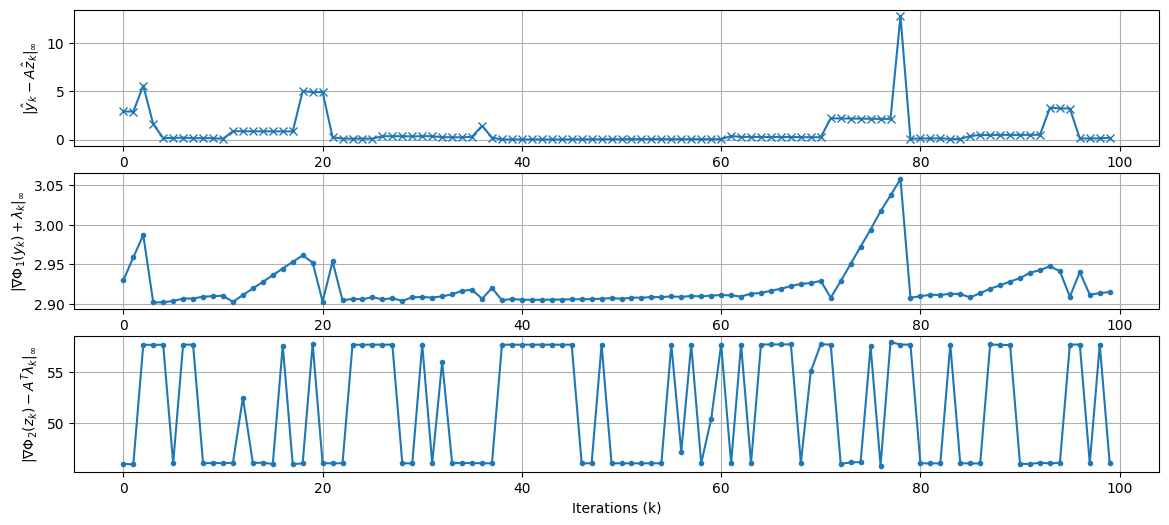

In [23]:
norm_yz_arr = convergence_data[i][0,:]
norm_dphi1_yl_arr = convergence_data[i][1,:]
norm_dphi2_yz_arr = convergence_data[i][2,:]

plt.figure(figsize=(14,6))

plt.subplot(3,1,1)
plt.plot(norm_yz_arr, marker='x')
plt.ylabel(rf'$|\hat y_k - A \hat z_k|_\infty$')
plt.grid()

plt.subplot(3,1,2)
plt.plot(norm_dphi1_yl_arr, marker='.')
plt.ylabel(rf'$|\nabla \Phi_1(y_{{k}}) + \lambda_k|_\infty$')
plt.grid()

plt.subplot(3,1,3)
plt.plot(norm_dphi2_yz_arr, marker='.')
plt.xlabel('Iterations (k)')
plt.ylabel(rf'$|\nabla \Phi_2(z_{{k}}) - A^T\lambda_k|_\infty$')
plt.grid()

plt.show()

In [24]:
# update mars schedule with final yb1
mars.sched_mat = yb1.reshape(-1, mars.n_waypoints)

# compute final probability associations
Pb_a = []
for i,a in enumerate(mars.agents):
    Pb = a.getPathAssociations(mars.sched_mat[i,:], mars.dist_mat, beta_max, gamma_t, coeff_t)
    Pb_a.append(Pb)

In [25]:
agent_routes, agent_schedules = createEnv.calc_agent_routes_and_schedules(mars, Pb_a, printRoutes=True)

route v0: [2, 0, 1], schedule: [ 0.   27.01 53.98]
route v1: [1, 0, 2], schedule: [ 0.56 28.37 55.67]


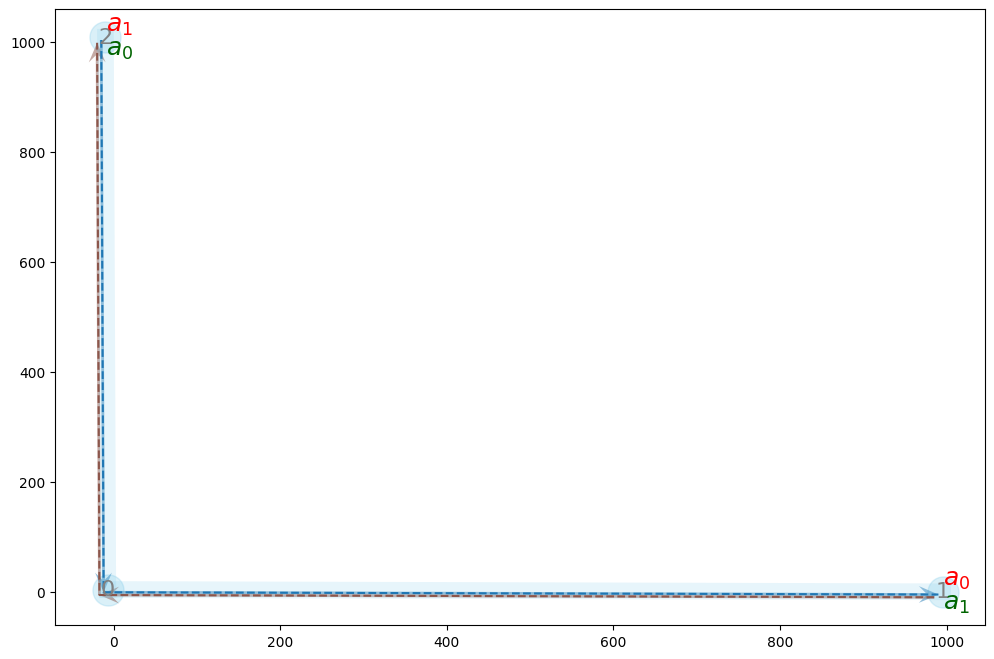

In [12]:
createEnv.plotNetwork(mars=mars, figuresize=(12,8), routes=agent_routes, agent_colors=agent_colors, showEdgeLength=False, plotPaths=True)

In [15]:
reach_mat = mars.calc_agent_reach_mat(mars.sched_mat, beta=beta_max, gamma=gamma_t, coeff=coeff_t)
filter_wp_final = np.ones(shape=reach_mat.shape)
filter_wp_final[reach_mat <= 1.0e-10] = 0.0


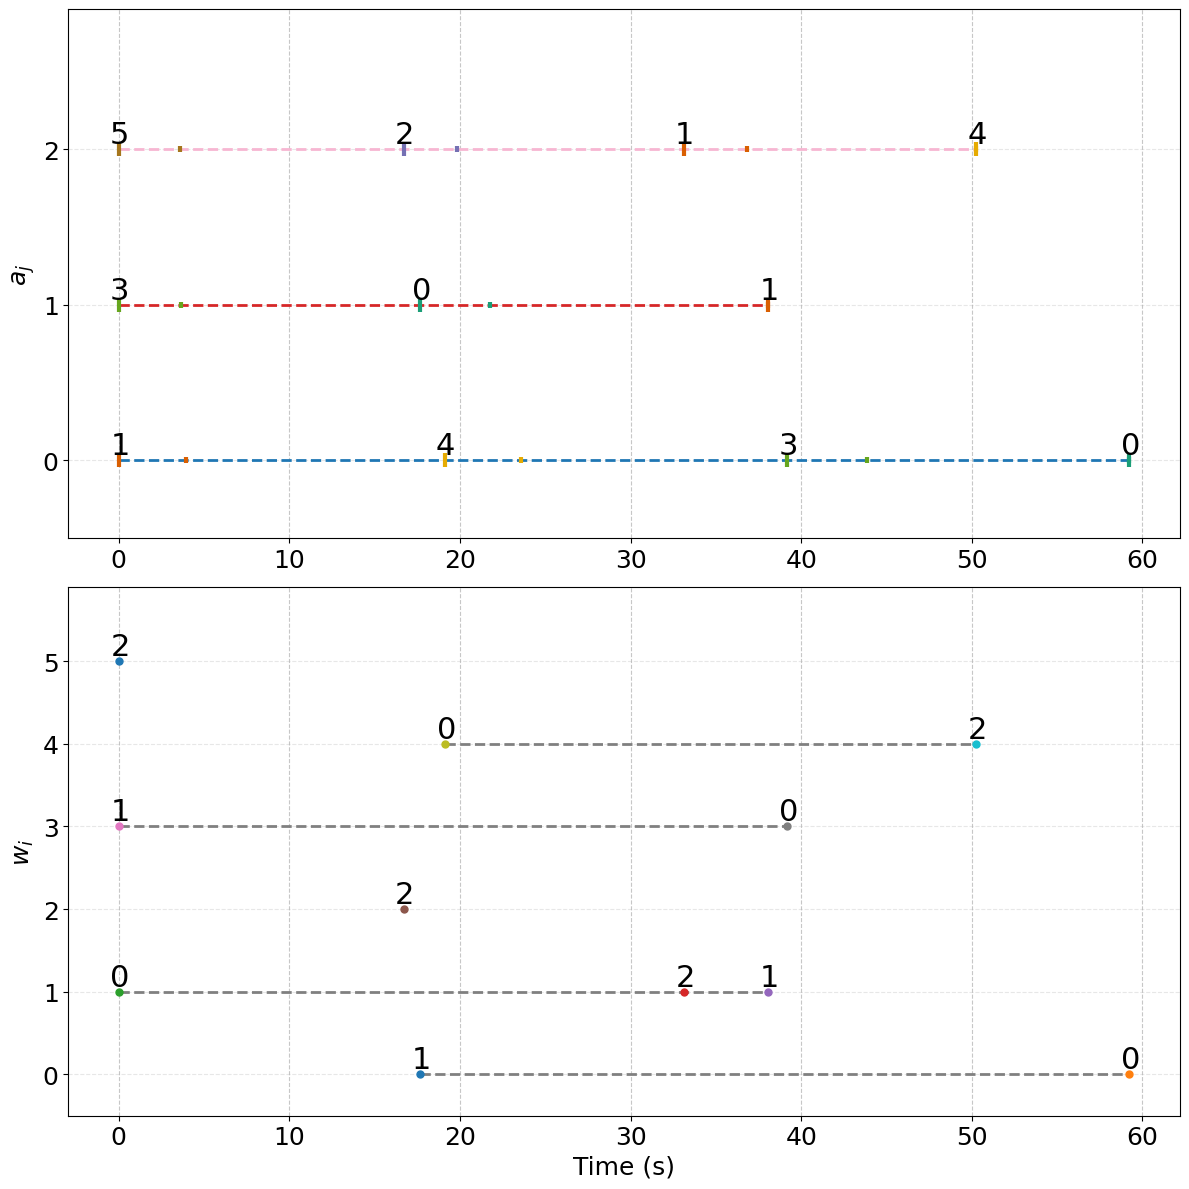

In [19]:

createEnv.plot_waypoint_agent_schedules(
    agent_routes, agent_schedules, mars.sched_mat, 
    filter_wp_final, mars.process_T, agent_colors,
    figuresize=(12,12))

### Write a function that penalizes the region outside $[0,1]$ quadratically

In [43]:

def penalty(x):
    fun = 0.0
    Ax = 10 * x**2
    Bx = 10 * (x-1)**2
    # if x < 0.0:
    #     fun = Ax
    # elif x > 1.0:
    #     fun = Bx
    fun = (np.tanh(-1000 * x)+1) * Ax + (np.tanh(1000*(x-1))+1) * Bx

    return fun

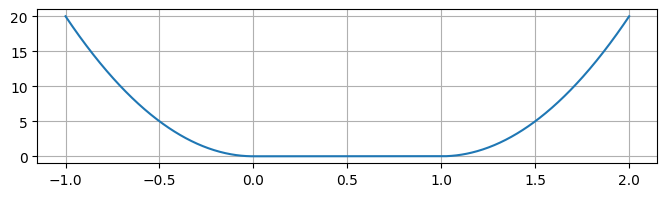

In [46]:
x_arr = np.linspace(-1, 2, 1000)
f_arr = [penalty(x) for x in x_arr]
plt.figure(figsize=(8,2))
plt.plot(x_arr, f_arr)
plt.grid()
plt.show()